# Look at the optimzation progress for DYCORS
David Eriksson <dme65@cornell.edu>

In [61]:
from pySOT.experimental_design import SymmetricLatinHypercube
from pySOT.strategy import DYCORSStrategy
from pySOT.surrogate import RBFInterpolant, CubicKernel, LinearTail
from pySOT.optimization_problems import Ackley, Levy
from pySOT.utils import progress_plot
from poap.controller import ThreadController, SerialController, BasicWorkerThread
import numpy as np

import matplotlib.pylab as plt
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)

## Use Ackley in 10 dimensions and run the optimizers 5 times

In [62]:
num_threads = 4
max_evals = 200
num_runs = 5

ackley = Ackley(dim=10)
print(ackley.info)

rbf = RBFInterpolant(
    dim=ackley.dim, kernel=CubicKernel(), tail=LinearTail(ackley.dim))
slhd = SymmetricLatinHypercube(dim=ackley.dim, num_pts=2*(ackley.dim+1))

10-dimensional Ackley function 
Global optimum: f(0,0,...,0) = 0


## Run asynchronously

In [63]:
results_async = np.zeros((max_evals, num_runs))
for i in range(num_runs):
    rbf.reset()  # This is important since the points are kept in the surrogate

    controller = ThreadController()
    controller.strategy = DYCORSStrategy(
        max_evals=max_evals, opt_prob=ackley, asynchronous=True, 
        exp_design=slhd, surrogate=rbf, num_cand=100*ackley.dim)

    for _ in range(num_threads):
        worker = BasicWorkerThread(controller, ackley.eval)
        controller.launch_worker(worker)

    result = controller.run()
    results_async[:, i] = np.array(
        [o.value for o in controller.fevals if o.value is not None])

## Run synchronously

In [64]:
results_sync = np.zeros((max_evals, num_runs))
for i in range(num_runs):
    rbf.reset()  # This is important since the points are kept in the surrogate

    controller = ThreadController()
    controller.strategy = DYCORSStrategy(
        max_evals=max_evals, opt_prob=ackley, asynchronous=False, 
        exp_design=slhd, surrogate=rbf, num_cand=100*ackley.dim,
        batch_size=num_threads)

    for _ in range(num_threads):
        worker = BasicWorkerThread(controller, ackley.eval)
        controller.launch_worker(worker)

    result = controller.run()
    results_sync[:, i] = np.array(
        [o.value for o in controller.fevals if o.value is not None])

## Run in serial

In [65]:
results_serial = np.zeros((max_evals, num_runs))
for i in range(num_runs):
    rbf.reset()  # This is important since the points are kept in the surrogate

    controller = SerialController(objective=ackley.eval)
    controller.strategy = DYCORSStrategy(
        max_evals=max_evals, opt_prob=ackley, asynchronous=False, 
        exp_design=slhd, surrogate=rbf, num_cand=100*ackley.dim,
        batch_size=1)

    result = controller.run()
    results_serial[:, i] = np.array(
        [o.value for o in controller.fevals if o.value is not None])

## Compare the results

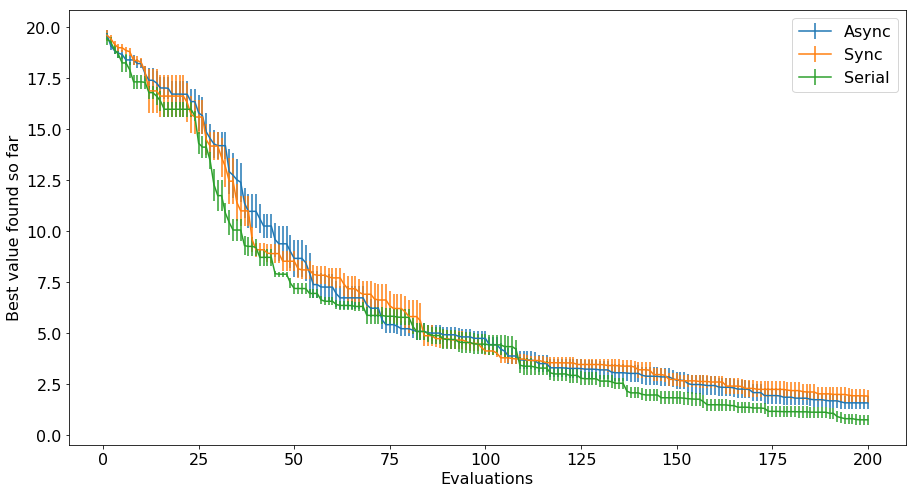

In [67]:
plt.figure(figsize=(15, 8))
for results in [results_async, results_sync, results_serial]:
    fvals = np.minimum.accumulate(results)
    plt.errorbar(np.arange(max_evals)+1, y=np.mean(fvals, axis=1), 
                 yerr=np.std(fvals, axis=1)/np.sqrt(float(num_runs)))

#     plt.plot(np.arange(0, fvals.shape[0]), np.minimum.accumulate(fvals), lw=2)
plt.ylabel("Best value found so far", fontsize=16)
plt.xlabel("Evaluations", fontsize=16)
plt.legend(("Async", "Sync", "Serial"), fontsize=16)
plt.show()